In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import seaborn as sns

In [2]:
data_path = "/home/comet/Documents/KAIST/Data-driven/IE437_HW2/data/log.csv"

data = pd.read_csv(data_path)
print(data)

             A         B         C         D         E      score
0     0.185171  0.012469  0.643883  0.000518  0.706477  64.948380
1     0.109382  0.264447  0.830440  0.936024  0.152748  67.864240
2     0.879817  0.268302  0.687127  0.694333  0.049413  72.356650
3     0.015239  0.792621  0.065918  0.493001  0.010857  69.130690
4     0.021096  0.480832  0.964605  0.124905  0.399937  65.814804
...        ...       ...       ...       ...       ...        ...
9987  0.588501  0.666145  0.692200  0.643742  0.299264  76.598465
9988  0.203448  0.201929  0.131689  0.419674  0.506553  71.323395
9989  0.945315  0.433905  0.629868  0.453814  0.964182  69.772125
9990  0.863595  0.919242  0.512188  0.706161  0.752385  74.662800
9991  0.228581  0.622028  0.558186  0.302629  0.844547  68.673020

[9992 rows x 6 columns]


/home/comet/anaconda3/envs/data-driven/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 768x576 with 0 Axes>

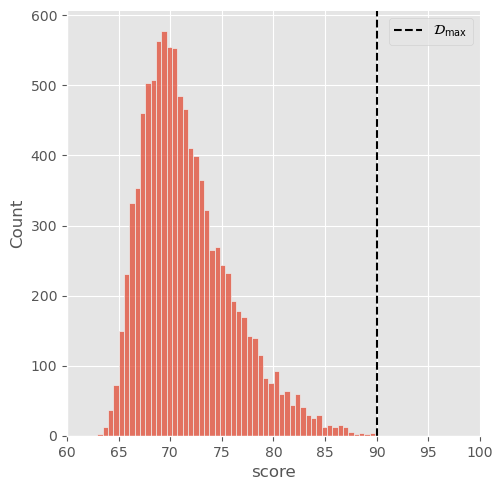

In [8]:
# Visualize Data Distribution
plt.style.use("ggplot")
plt.figure(dpi=120)
sns.displot(data['score'])
plt.xlim(60, 100)
plt.axvline(90, linestyle="--", color="black", label="$\mathcal{D}_{\max}$")
plt.legend()

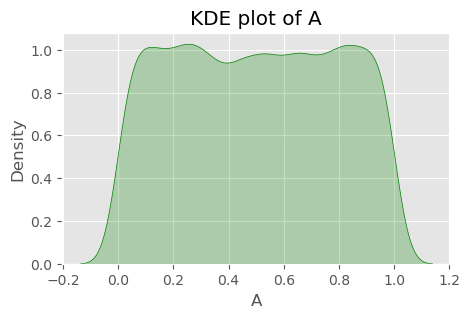

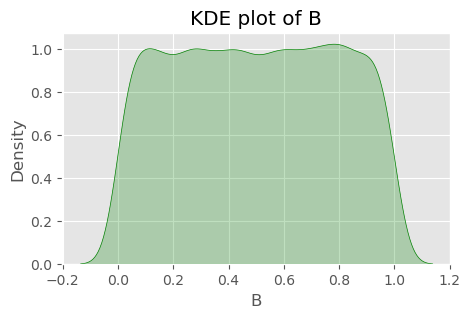

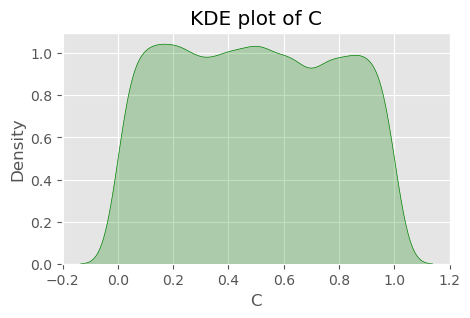

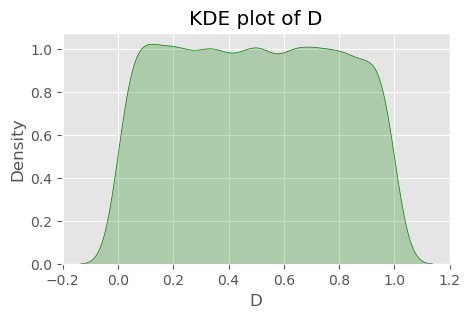

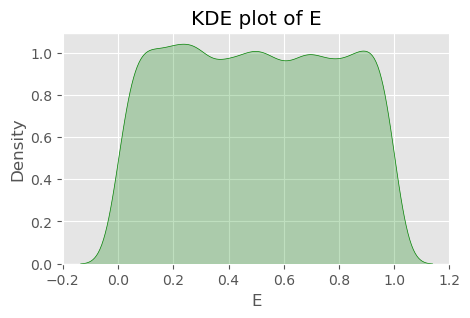

In [6]:
# Visualize Data Distribution using KDE plot
for column in ['A', 'B', 'C', 'D', 'E']:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data[column], color='g', fill=True)
    plt.title(f'KDE plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [55]:
# 'score'가 80보다 큰 행의 수 계산
num_greater_80 = (data['score'] > 80).sum()

# 'score'가 80 이하인 행의 수 계산
num_less_equal_80 = (data['score'] <= 80).sum()

print(f"'score'가 80보다 큰 행의 수: {num_greater_80}")
print(f"'score'가 80 이하인 행의 수: {num_less_equal_80}")

'score'가 80보다 큰 행의 수: 531
'score'가 80 이하인 행의 수: 9461


In [58]:
# weight 조절

# score가 80보다 큰 행 선택
high_score_data = data[data['score'] > 80]

# 데이터에 high_score_data 추가
weighted_data = pd.concat([data, high_score_data]).reset_index(drop=True)
weighted_data = pd.concat([weighted_data, high_score_data]).reset_index(drop=True)

<Figure size 960x660 with 0 Axes>

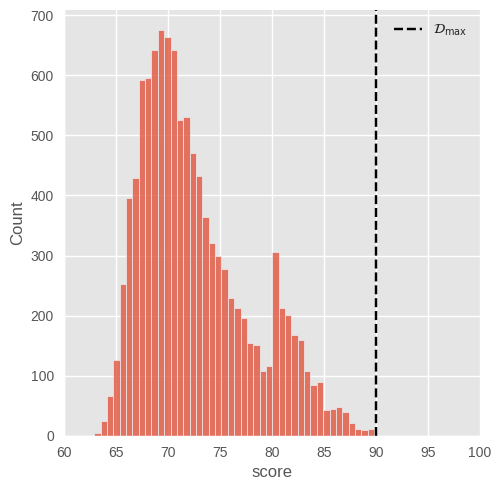

In [59]:
# Visualize Data Distribution
plt.style.use("ggplot")
plt.figure(dpi=120)
sns.displot(weighted_data['score'])
plt.xlim(60, 100)
plt.axvline(90, linestyle="--", color="black", label="$\mathcal{D}_{\max}$")
plt.legend()

In [60]:
from pycaret.regression import *

exp_reg = setup(data = weighted_data, target = 'score', session_id = 123)

,Description,Value
0,Session id,123
1,Target,score
2,Target type,Regression
3,Original data shape,"(11054, 6)"
4,Transformed data shape,"(11054, 6)"
5,Transformed train set shape,"(7737, 6)"
6,Transformed test set shape,"(3317, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [61]:
best = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2836,0.1373,0.3702,0.9950,0.0049,0.0039,1.1210
lightgbm,Light Gradient Boosting Machine,0.3583,0.2133,0.4615,0.9923,0.0062,0.0049,0.9090
et,Extra Trees Regressor,0.4498,0.3775,0.6140,0.9864,0.0084,0.0063,0.0510
rf,Random Forest Regressor,0.5176,0.4636,0.6805,0.9833,0.0092,0.0072,0.1060
gbr,Gradient Boosting Regressor,0.5971,0.7077,0.8400,0.9745,0.0108,0.0080,0.0900
knn,K Neighbors Regressor,0.6801,0.7608,0.8718,0.9726,0.0116,0.0093,0.0050
dt,Decision Tree Regressor,0.7757,1.1736,1.0831,0.9576,0.0146,0.0108,0.0080
ada,AdaBoost Regressor,1.7993,4.5578,2.1346,0.8356,0.0289,0.0250,0.0380
huber,Huber Regressor,2.2040,8.5377,2.9210,0.6925,0.0379,0.0295,0.0050
ridge,Ridge Regression,2.2252,8.4214,2.9013,0.6966,0.0378,0.0300,0.0750


In [62]:
# 선택한 모델들을 앙상블
blended = blend_models(estimator_list=best)

# 앙상블 모델 학습
final_model = finalize_model(blended)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3057,0.1672,0.4089,0.9938,0.0055,0.0042
1,0.3012,0.1557,0.3945,0.9944,0.0053,0.0041
2,0.3090,0.1783,0.4222,0.9937,0.0056,0.0043
3,0.3041,0.1493,0.3864,0.9944,0.0053,0.0042
4,0.3207,0.1688,0.4109,0.9940,0.0056,0.0044
5,0.2878,0.1360,0.3688,0.9953,0.0050,0.0040
6,0.3050,0.1600,0.4000,0.9945,0.0054,0.0042
7,0.3011,0.1564,0.3954,0.9940,0.0054,0.0042
8,0.2961,0.1457,0.3817,0.9947,0.0052,0.0041


In [37]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [68]:
# hyperparameter tuning 
tuned_model = tune_model(final_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:26:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2765,0.1398,0.3738,0.9948,0.0050,0.0038
1,0.2723,0.1252,0.3538,0.9955,0.0047,0.0037
2,0.2838,0.1474,0.3839,0.9948,0.0051,0.0039
3,0.2768,0.1216,0.3487,0.9954,0.0047,0.0038
4,0.2921,0.1422,0.3771,0.9949,0.0051,0.0040
5,0.2661,0.1131,0.3364,0.9961,0.0045,0.0037
6,0.2735,0.1292,0.3594,0.9956,0.0048,0.0037
7,0.2690,0.1248,0.3533,0.9952,0.0048,0.0037
8,0.2692,0.1172,0.3424,0.9957,0.0046,0.0037


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [69]:
def blackbox_function(A, B, C, D, E):
    # 입력 데이터 프레임 생성
    input_data = pd.DataFrame([[A, B, C, D, E]], columns=['A', 'B', 'C', 'D', 'E'])
    
    # 예측 모델 사용
    prediction = predict_model(final_model, data=input_data)

    # 예측 열의 이름 찾기
    label_col = prediction.columns[-1]

    # 예측 값 반환 - 마지막 열의 첫 번째 값을 반환
    return prediction[label_col].iloc[0]

In [74]:
pbounds = {
    'A': (data['A'].min(), data['A'].max()),
    'B': (data['B'].min(), data['B'].max()),
    'C': (data['C'].min(), data['C'].max()),
    'D': (data['D'].min(), data['D'].max()),
    'E': (data['E'].min(), data['E'].max())
}
# pbounds = {'A': (0.5, 0.9), 'B': (0.5, 0.7), 'C': (0.1, 0.3), 'D': (0.7, 1), 'E': (0.2, 0.5)}

# Bayesian Optimization
optimizer = BayesianOptimization(f=blackbox_function, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |     A     |     B     |     C     |     D     |     E     |
-------------------------------------------------------------------------------------


| 1         | 71.32     | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.1562    |


| 2         | 66.89     | 0.156     | 0.05809   | 0.8661    | 0.6012    | 0.7081    |


| 3         | 65.67     | 0.02064   | 0.9699    | 0.8324    | 0.2124    | 0.182     |


| 4         | 71.02     | 0.1834    | 0.3042    | 0.5249    | 0.432     | 0.2914    |


| 5         | 73.88     | 0.6118    | 0.1395    | 0.2924    | 0.3664    | 0.4562    |


| 6         | 73.65     | 0.7851    | 0.1997    | 0.5144    | 0.5925    | 0.04667   |


| 7         | 71.91     | 0.6075    | 0.1705    | 0.06542   | 0.9489    | 0.9656    |


| 8         | 82.12     | 0.8083    | 0.3046    | 0.09802   | 0.6843    | 0.4403    |


| 9         | 73.99     | 0.1221    | 0.4952    | 0.03477   | 0.9093    | 0.2589    |


| 10        | 76.67     | 0.6625    | 0.3117    | 0.5202    | 0.5468    | 0.185     |


| 11        | 86.69     | 0.8285    | 0.5591    | 0.1669    | 0.6982    | 0.3534    |


| 12        | 78.13     | 0.9999    | 0.8462    | 0.000397  | 0.5573    | 0.4451    |


| 13        | 83.24     | 0.9398    | 0.591     | 0.2034    | 1.0       | 0.2968    |


| 14        | 80.18     | 0.7974    | 0.5825    | 0.000397  | 0.7267    | 0.04857   |


| 15        | 80.15     | 0.9999    | 0.5997    | 0.4581    | 0.7155    | 0.5221    |


| 16        | 87.63     | 0.6653    | 0.7095    | 0.1529    | 0.8598    | 0.4799    |


| 17        | 69.5      | 0.07551   | 0.8119    | 0.4668    | 0.3059    | 0.2989    |


| 18        | 80.4      | 0.9871    | 0.6413    | 0.443     | 0.7357    | 0.5357    |


| 19        | 74.96     | 0.539     | 1.0       | 0.000397  | 1.0       | 0.7687    |


| 20        | 69.22     | 0.1336    | 0.7372    | 0.3016    | 0.1896    | 0.227     |


| 21        | 71.85     | 0.2714    | 0.6516    | 0.06253   | 0.7471    | 0.9593    |


| 22        | 87.76     | 0.6341    | 0.6063    | 0.3108    | 0.888     | 0.343     |


| 23        | 83.61     | 0.6716    | 0.8427    | 0.2326    | 0.8807    | 0.2682    |


| 24        | 87.28     | 0.6645    | 0.54      | 0.0918    | 0.9264    | 0.3809    |


| 25        | 88.18     | 0.6184    | 0.5919    | 0.2054    | 0.7246    | 0.4273    |


| 26        | 64.68     | 0.9999    | 1.0       | 0.9999    | 0.0001257 | 1.0       |


| 27        | 87.17     | 0.671     | 0.6227    | 0.2618    | 0.9326    | 0.4976    |


| 28        | 88.81     | 0.7132    | 0.5839    | 0.2107    | 0.8176    | 0.4058    |


| 29        | 88.09     | 0.6886    | 0.6102    | 0.08737   | 0.7675    | 0.42      |


| 30        | 88.89     | 0.6448    | 0.6156    | 0.1853    | 0.8148    | 0.3645    |


| 31        | 88.25     | 0.6818    | 0.5018    | 0.254     | 0.861     | 0.3343    |


| 32        | 88.68     | 0.6287    | 0.5667    | 0.1965    | 0.8311    | 0.41      |


| 33        | 88.91     | 0.6717    | 0.5705    | 0.2088    | 0.7841    | 0.3488    |


| 34        | 88.86     | 0.6779    | 0.6219    | 0.2166    | 0.7855    | 0.3808    |


| 35        | 89.01     | 0.6845    | 0.5888    | 0.189     | 0.823     | 0.3632    |


| 36        | 89.1      | 0.6733    | 0.5882    | 0.2107    | 0.8265    | 0.3679    |


| 37        | 66.04     | 0.9999    | 1.031e-05 | 0.9999    | 1.0       | 1.0       |


| 38        | 66.08     | 0.9999    | 1.031e-05 | 0.000397  | 0.0001257 | 1.0       |


| 39        | 88.96     | 0.6921    | 0.592     | 0.2316    | 0.8345    | 0.3425    |


| 40        | 89.08     | 0.6737    | 0.598     | 0.2108    | 0.8599    | 0.3745    |


| 41        | 88.81     | 0.6608    | 0.5829    | 0.2109    | 0.8519    | 0.3508    |


| 42        | 68.48     | 0.9999    | 1.0       | 0.9999    | 1.0       | 0.0002333 |


| 43        | 65.33     | 6.431e-05 | 1.0       | 0.9999    | 1.0       | 1.0       |


| 44        | 68.06     | 0.9999    | 1.0       | 0.000397  | 0.0001257 | 0.0002333 |


| 45        | 65.15     | 6.431e-05 | 1.0       | 0.000397  | 0.0001257 | 1.0       |


| 46        | 65.47     | 6.431e-05 | 1.031e-05 | 0.000397  | 0.0001257 | 0.0002333 |


| 47        | 65.26     | 6.431e-05 | 1.031e-05 | 0.9999    | 1.0       | 0.0002333 |


| 48        | 64.7      | 0.9999    | 1.031e-05 | 0.9999    | 0.0001257 | 0.0002333 |


| 49        | 71.48     | 0.9999    | 1.031e-05 | 0.000397  | 1.0       | 0.0002333 |


| 50        | 85.82     | 0.7148    | 0.725     | 0.022     | 0.9187    | 0.3988    |


| 51        | 83.27     | 0.5599    | 0.5604    | 0.000397  | 0.5771    | 0.3587    |


| 52        | 88.15     | 0.7128    | 0.5347    | 0.312     | 0.7858    | 0.3587    |


| 53        | 88.72     | 0.697     | 0.6347    | 0.2345    | 0.8683    | 0.3895    |


| 54        | 69.59     | 6.431e-05 | 1.0       | 0.000397  | 1.0       | 0.0002333 |


| 55        | 63.24     | 6.431e-05 | 1.031e-05 | 0.9999    | 0.0001257 | 1.0       |


| 56        | 88.44     | 0.71      | 0.5572    | 0.2241    | 0.8913    | 0.3931    |


| 57        | 66.89     | 0.9999    | 1.0       | 0.9999    | 1.0       | 1.0       |


| 58        | 85.33     | 0.5497    | 0.6811    | 0.1387    | 1.0       | 0.4574    |


| 59        | 72.36     | 0.9999    | 0.7167    | 0.000397  | 1.0       | 1.0       |


| 60        | 66.57     | 6.431e-05 | 1.031e-05 | 0.000397  | 1.0       | 1.0       |


| 61        | 66.67     | 0.9999    | 1.0       | 0.000397  | 0.0001257 | 1.0       |


| 62        | 88.78     | 0.6675    | 0.6172    | 0.1691    | 0.8566    | 0.4207    |


| 63        | 85.92     | 0.5381    | 0.7067    | 0.2722    | 0.8185    | 0.4704    |


| 64        | 74.45     | 0.9999    | 1.0       | 0.000397  | 1.0       | 0.0002333 |


| 65        | 65.45     | 0.9999    | 1.0       | 0.9999    | 0.0001257 | 0.0002333 |


| 66        | 89.08     | 0.6644    | 0.5996    | 0.2305    | 0.8364    | 0.3955    |


| 67        | 89.06     | 0.6729    | 0.6071    | 0.2095    | 0.8343    | 0.3834    |


| 68        | 67.22     | 0.9999    | 1.031e-05 | 0.9999    | 1.0       | 0.0002333 |


| 69        | 66.7      | 0.9999    | 1.031e-05 | 0.000397  | 0.0001257 | 0.0002333 |


| 70        | 67.97     | 6.431e-05 | 1.031e-05 | 0.000397  | 1.0       | 0.0002333 |


| 71        | 81.83     | 0.5452    | 0.829     | 0.000397  | 0.6946    | 0.4028    |


| 72        | 88.84     | 0.6783    | 0.5562    | 0.2424    | 0.8097    | 0.3863    |


| 73        | 79.95     | 0.8149    | 0.4521    | 0.4415    | 1.0       | 0.1531    |


| 74        | 65.86     | 6.431e-05 | 1.0       | 0.9999    | 1.0       | 0.0002333 |


| 75        | 86.76     | 0.7898    | 0.4671    | 0.2384    | 0.7924    | 0.2685    |


| 76        | 64.49     | 6.431e-05 | 1.031e-05 | 0.000397  | 0.0001257 | 1.0       |


| 77        | 63.94     | 0.9999    | 1.031e-05 | 0.9999    | 0.0001257 | 1.0       |


| 78        | 63.59     | 6.431e-05 | 1.031e-05 | 0.9999    | 0.0001257 | 0.0002333 |


| 79        | 87.08     | 0.6527    | 0.6341    | 0.1964    | 0.6629    | 0.3055    |


| 80        | 88.92     | 0.6842    | 0.5885    | 0.2328    | 0.843     | 0.3783    |


| 81        | 63.78     | 6.431e-05 | 1.0       | 0.9999    | 0.0001257 | 1.0       |


| 82        | 73.82     | 0.6305    | 1.031e-05 | 0.3678    | 1.0       | 0.426     |


| 83        | 80.75     | 0.7896    | 0.5663    | 0.000397  | 0.6156    | 0.6948    |


| 84        | 79.39     | 0.9999    | 0.3852    | 0.000397  | 1.0       | 0.5417    |


| 85        | 76.95     | 0.9999    | 1.0       | 0.1756    | 1.0       | 0.555     |


| 86        | 76.37     | 0.9999    | 0.7685    | 0.4087    | 0.634     | 0.0002333 |


| 87        | 64.84     | 6.431e-05 | 1.031e-05 | 0.9999    | 1.0       | 1.0       |


| 88        | 84.01     | 0.5592    | 0.423     | 0.4063    | 0.7776    | 0.4316    |


| 89        | 85.71     | 0.8373    | 0.5473    | 0.000397  | 0.8275    | 0.4151    |


| 90        | 67.85     | 6.431e-05 | 1.0       | 0.000397  | 1.0       | 1.0       |


| 91        | 84.74     | 0.6589    | 0.5966    | 0.3551    | 0.7507    | 0.1874    |


| 92        | 86.36     | 0.7087    | 0.6509    | 0.1817    | 1.0       | 0.3247    |


| 93        | 87.31     | 0.7211    | 0.4954    | 0.1614    | 0.7747    | 0.5159    |


| 94        | 66.11     | 6.431e-05 | 1.0       | 0.000397  | 0.0001257 | 0.0002333 |


| 95        | 82.88     | 0.7199    | 0.5836    | 0.3217    | 0.5301    | 0.5268    |


| 96        | 84.15     | 0.676     | 0.5777    | 0.000397  | 0.9605    | 0.5895    |


| 97        | 87.77     | 0.6256    | 0.6484    | 0.2252    | 0.8841    | 0.4016    |


| 98        | 77.13     | 0.6427    | 1.0       | 0.4046    | 0.6619    | 0.6717    |


| 99        | 81.5      | 0.6634    | 0.6394    | 0.3045    | 0.7755    | 0.7312    |


| 100       | 80.73     | 0.6376    | 0.6862    | 0.5624    | 0.7774    | 0.4357    |


| 101       | 69.36     | 0.9999    | 1.031e-05 | 0.000397  | 0.803     | 1.0       |


| 102       | 71.35     | 0.7858    | 0.6714    | 0.3103    | 0.1173    | 0.7037    |


| 103       | 75.04     | 0.6065    | 1.0       | 0.000397  | 0.5675    | 0.0002333 |


| 104       | 87.58     | 0.5868    | 0.5967    | 0.3123    | 0.7489    | 0.3593    |


| 105       | 85.84     | 0.8462    | 0.6663    | 0.1305    | 0.8278    | 0.5428    |


| 106       | 75.7      | 0.3706    | 1.0       | 0.4262    | 1.0       | 0.5196    |


| 107       | 76.7      | 0.9999    | 0.4669    | 0.000397  | 0.3993    | 0.3661    |


| 108       | 73.76     | 0.6092    | 0.0964    | 0.4816    | 0.8669    | 0.1415    |


| 109       | 86.8      | 0.8095    | 0.6869    | 0.1859    | 0.818     | 0.2536    |


| 110       | 87.77     | 0.7559    | 0.6144    | 0.1357    | 0.9076    | 0.4099    |


| 111       | 87.99     | 0.6713    | 0.6072    | 0.2331    | 0.7878    | 0.5102    |


| 112       | 84.02     | 0.7541    | 0.3681    | 0.3226    | 0.8779    | 0.3956    |


| 113       | 78.93     | 0.585     | 0.2557    | 0.000397  | 1.0       | 0.3801    |


| 114       | 86.44     | 0.7848    | 0.6052    | 0.3367    | 0.8055    | 0.2376    |


| 115       | 88.87     | 0.6577    | 0.5868    | 0.2094    | 0.7968    | 0.4067    |


| 116       | 79.93     | 0.3959    | 0.4939    | 0.2799    | 1.0       | 0.604     |


| 117       | 68.15     | 0.4376    | 0.9148    | 0.9868    | 0.485     | 0.1709    |


| 118       | 84.03     | 0.5068    | 0.6114    | 0.000397  | 0.7917    | 0.5347    |


| 119       | 81.14     | 0.4583    | 0.6732    | 0.2235    | 0.5727    | 0.5383    |


| 120       | 86.13     | 0.7195    | 0.7375    | 0.1563    | 0.6839    | 0.5015    |


| 121       | 88.48     | 0.6872    | 0.6419    | 0.2167    | 0.7946    | 0.2938    |


| 122       | 81.08     | 0.8879    | 0.565     | 0.005259  | 0.6591    | 0.6504    |


| 123       | 87.04     | 0.6636    | 0.451     | 0.249     | 0.714     | 0.3512    |


| 124       | 88.79     | 0.7127    | 0.6247    | 0.1853    | 0.8543    | 0.3441    |


| 125       | 88.71     | 0.6533    | 0.6048    | 0.2515    | 0.7956    | 0.3535    |


| 126       | 88.09     | 0.6211    | 0.5602    | 0.2972    | 0.8317    | 0.4438    |


| 127       | 79.77     | 0.4716    | 0.52      | 0.4892    | 1.0       | 0.2699    |


| 128       | 88.56     | 0.7349    | 0.5825    | 0.2198    | 0.7888    | 0.3154    |


| 129       | 87.48     | 0.6835    | 0.6766    | 0.09357   | 0.7465    | 0.3244    |


| 130       | 70.62     | 0.01867   | 0.915     | 0.1758    | 0.5463    | 0.3216    |


| 131       | 88.93     | 0.6688    | 0.5815    | 0.2103    | 0.866     | 0.4303    |


| 132       | 88.22     | 0.7395    | 0.5598    | 0.1934    | 0.712     | 0.4459    |


| 133       | 87.65     | 0.7334    | 0.5946    | 0.2571    | 0.889     | 0.2585    |


| 134       | 88.97     | 0.6656    | 0.5918    | 0.206     | 0.8507    | 0.3963    |


| 135       | 77.1      | 0.9999    | 0.5239    | 0.000397  | 1.0       | 0.0002333 |


| 136       | 78.47     | 0.8593    | 1.0       | 0.3464    | 0.6394    | 0.3038    |


| 137       | 71.51     | 0.9999    | 1.0       | 0.2942    | 0.6257    | 1.0       |


| 138       | 75.11     | 0.2552    | 0.5982    | 0.0213    | 0.5566    | 0.6564    |


| 139       | 86.18     | 0.644     | 0.5118    | 0.1706    | 1.0       | 0.4804    |


| 140       | 87.39     | 0.8193    | 0.5267    | 0.2329    | 0.7652    | 0.4612    |


| 141       | 87.49     | 0.6624    | 0.6035    | 0.1374    | 0.8764    | 0.5186    |


| 142       | 88.96     | 0.6803    | 0.6104    | 0.2046    | 0.8155    | 0.3473    |


| 143       | 85.45     | 0.6493    | 0.4641    | 0.000397  | 0.7591    | 0.374     |


| 144       | 67.59     | 0.6699    | 0.4047    | 0.8502    | 0.3437    | 0.9755    |


| 145       | 67.09     | 0.6809    | 0.911     | 0.9792    | 0.3188    | 0.7289    |


| 146       | 68.93     | 0.7184    | 0.5489    | 0.7305    | 0.2298    | 0.8471    |


| 147       | 85.46     | 0.499     | 0.6179    | 0.1411    | 0.7252    | 0.3426    |


| 148       | 72.31     | 0.1655    | 0.5717    | 0.124     | 0.3593    | 0.4533    |


| 149       | 88.51     | 0.7331    | 0.4895    | 0.1689    | 0.7904    | 0.3831    |


| 150       | 86.27     | 0.6499    | 0.7495    | 0.2951    | 0.6957    | 0.3768    |


| 151       | 88.76     | 0.6583    | 0.6189    | 0.2506    | 0.8209    | 0.4266    |


| 152       | 67.96     | 0.6855    | 0.9321    | 0.8708    | 0.1941    | 0.5138    |


| 153       | 87.53     | 0.5849    | 0.6414    | 0.09738   | 0.801     | 0.4363    |


| 154       | 88.47     | 0.7195    | 0.5286    | 0.215     | 0.7754    | 0.3696    |


| 155       | 74.87     | 0.7026    | 1.0       | 0.4545    | 1.0       | 0.0002333 |


| 156       | 72.6      | 0.8215    | 0.1157    | 0.6732    | 0.7127    | 0.4352    |


| 157       | 86.16     | 0.7775    | 0.4363    | 0.1085    | 0.8762    | 0.3291    |


| 158       | 82.78     | 0.6539    | 0.6551    | 0.2969    | 0.8043    | 0.6975    |


| 159       | 88.37     | 0.7702    | 0.5477    | 0.1366    | 0.7896    | 0.441     |


| 160       | 86.64     | 0.6507    | 0.5028    | 0.3548    | 0.827     | 0.3098    |


| 161       | 88.16     | 0.7936    | 0.661     | 0.2565    | 0.7195    | 0.4336    |


| 162       | 85.81     | 0.7887    | 0.6321    | 0.3451    | 0.6479    | 0.3504    |


| 163       | 83.26     | 0.9999    | 0.6814    | 0.2164    | 0.7416    | 0.3831    |


| 164       | 88.7      | 0.6728    | 0.5345    | 0.1839    | 0.8094    | 0.3158    |


| 165       | 88.32     | 0.7612    | 0.6435    | 0.1805    | 0.7669    | 0.4543    |


| 166       | 87.12     | 0.6465    | 0.4404    | 0.1728    | 0.8206    | 0.391     |


| 167       | 88.16     | 0.727     | 0.6106    | 0.3056    | 0.7298    | 0.4627    |


| 168       | 78.33     | 0.5509    | 0.6715    | 0.000397  | 1.0       | 0.0002333 |


| 169       | 75.57     | 0.5032    | 0.3171    | 0.000397  | 0.5431    | 0.0002333 |


| 170       | 87.99     | 0.7043    | 0.5355    | 0.1124    | 0.7589    | 0.3232    |


| 171       | 88.46     | 0.7079    | 0.5365    | 0.1494    | 0.8419    | 0.4207    |


| 172       | 86.46     | 0.7545    | 0.5299    | 0.06911   | 0.6816    | 0.4528    |


| 173       | 88.92     | 0.6563    | 0.5966    | 0.2228    | 0.8204    | 0.3795    |


| 174       | 88.14     | 0.7116    | 0.6453    | 0.3089    | 0.7643    | 0.344     |


| 175       | 85.8      | 0.6743    | 0.4592    | 0.01442   | 0.7458    | 0.3812    |


| 176       | 88.78     | 0.6772    | 0.5513    | 0.2367    | 0.8341    | 0.4588    |


| 177       | 76.7      | 0.7026    | 0.1716    | 0.02993   | 0.8427    | 0.645     |


| 178       | 88.26     | 0.7096    | 0.6353    | 0.2477    | 0.7037    | 0.4131    |


| 179       | 88.25     | 0.63      | 0.5742    | 0.135     | 0.7664    | 0.3692    |


| 180       | 88.42     | 0.6899    | 0.554     | 0.2479    | 0.7927    | 0.288     |


| 181       | 87.98     | 0.6547    | 0.6548    | 0.1165    | 0.8499    | 0.354     |


| 182       | 68.08     | 0.3856    | 0.02544   | 0.07973   | 0.1035    | 0.4216    |


| 183       | 68.54     | 0.807     | 0.8491    | 0.8643    | 0.7061    | 0.9891    |


| 184       | 72.28     | 0.8001    | 0.9835    | 0.2267    | 0.2226    | 0.2029    |


| 185       | 86.77     | 0.7768    | 0.7189    | 0.1651    | 0.6852    | 0.3084    |


| 186       | 88.45     | 0.7286    | 0.5415    | 0.1813    | 0.8505    | 0.3136    |


| 187       | 89.04     | 0.686     | 0.5686    | 0.2075    | 0.8187    | 0.3508    |


| 188       | 85.89     | 0.6799    | 0.5427    | 0.3438    | 1.0       | 0.384     |


| 189       | 88.28     | 0.6506    | 0.6816    | 0.1645    | 0.764     | 0.3892    |


| 190       | 88.77     | 0.6854    | 0.6134    | 0.197     | 0.8743    | 0.3681    |


| 191       | 70.08     | 6.431e-05 | 0.5513    | 0.4783    | 1.0       | 0.0002333 |


| 192       | 82.52     | 0.8361    | 0.7725    | 0.4069    | 1.0       | 0.3139    |


| 193       | 77.35     | 0.3211    | 0.7364    | 0.000397  | 1.0       | 0.5081    |


| 194       | 71.74     | 0.5744    | 1.0       | 0.4455    | 1.0       | 1.0       |


| 195       | 70.14     | 0.5394    | 0.4764    | 0.9999    | 1.0       | 0.4912    |


| 196       | 69.73     | 0.3226    | 0.1619    | 0.7815    | 0.7377    | 0.6095    |


| 197       | 87.58     | 0.6716    | 0.5085    | 0.301     | 0.7146    | 0.4706    |


| 198       | 68.93     | 0.6381    | 0.5195    | 0.4254    | 0.0001257 | 0.0002333 |


| 199       | 70.87     | 0.731     | 0.5478    | 0.02952   | 0.07151   | 0.1372    |


| 200       | 85.72     | 0.8048    | 0.7772    | 0.1965    | 0.8038    | 0.4084    |


| 201       | 87.51     | 0.8275    | 0.613     | 0.1347    | 0.8286    | 0.3805    |


| 202       | 69.4      | 0.8718    | 0.1692    | 0.03024   | 0.1045    | 0.2556    |


| 203       | 89.01     | 0.6846    | 0.6266    | 0.1685    | 0.8094    | 0.4407    |


| 204       | 88.25     | 0.7071    | 0.6492    | 0.1458    | 0.815     | 0.41      |


| 205       | 84.81     | 0.7573    | 0.5986    | 0.000397  | 1.0       | 0.2786    |


| 206       | 71.55     | 0.7535    | 0.02196   | 0.3868    | 0.3661    | 0.391     |


| 207       | 75.85     | 0.9999    | 0.411     | 0.4335    | 1.0       | 0.7676    |


| 208       | 86.08     | 0.8253    | 0.6319    | 0.2417    | 0.6827    | 0.5333    |


| 209       | 83.08     | 0.7306    | 0.78      | 0.1517    | 1.0       | 0.5812    |


| 210       | 88.63     | 0.7138    | 0.6097    | 0.1969    | 0.8308    | 0.4727    |


In [75]:
# 최적 파라미터와 예측 결과 출력
print("Best Parameters: ", optimizer.max['params'])
print("Best Score: ", optimizer.max['target'])

Best Parameters:  {'A': 0.6732887755433055, 'B': 0.5881784263934243, 'C': 0.21074923828873393, 'D': 0.8264754748150501, 'E': 0.3679376954636409}
Best Score:  89.09833957652522


In [73]:
# find_value = [0.7054, 0.6027, 0.1901, 0.8088, 0.3954] # svm 88.67
# find_value= [0.702024386768685, 0.5981451009008234, 0.19719569949487678, 0.7905103192329689,  0.34372716858961566] # lightgbm 88.63
# find_value=[0.6991749806513763, 0.6090184030451627, 0.19904463287166493, 0.7965212958591288, 0.38427605728597597] # 89.09
find_value=[0.6976193120651549, 0.6009214180271035, 0.2071009008656542, 0.7978415143037471, 0.38491599154018274]

# 앙상블 모델 + tuning -> 베이지안최적화 # 
predict_model(tuned_model, data=pd.DataFrame([find_value], columns=['A', 'B', 'C', 'D', 'E'])) 


,A,B,C,D,E,prediction_label
0,0.697619,0.600921,0.207101,0.797841,0.384916,89.346887
